In [125]:
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt

In [126]:
#метод k-means
class Kmeans:

    centers_clusters = None
    inertia = 0.0
    labels = None
    __dist_matrix = None

    def __init__(self, n_clusters, select="k-means++", n_init=10, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.select = select
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state

    def __calc_inertia(self, X):
        _inertia = 0.0
        for i in range(self.n_clusters):
            tmp = X[[j for j in range(X.shape[0]) if self.labels[j] == i], :].copy()
            if(tmp.size != 0):
                _inertia += (np.linalg.norm((tmp-self.centers_clusters[i]), axis=1)**2).sum()
        return _inertia

    def __recalc_centers(self, X):
        centers = np.zeros(self.centers_clusters.shape, dtype="float64")
        for i in range(self.n_clusters):
            tmp = X[[j for j in range(X.shape[0]) if self.labels[j] == i], :].copy()
            if(tmp.size != 0):
                centers[i] = np.array(tmp).mean(axis=0)
        return centers

    def __calc(self, X):
        _iter = 0
        while(_iter <= self.max_iter):
            # не очень оптимально по памяти пользоваться трехмерными массивами,но затраты по
            # времени уменьшаются на 10%
            tmp = X.reshape(1, X.shape[0], -1)
            self.centers_clusters = self.centers_clusters.reshape(self.centers_clusters.shape[0], 1, -1)
            self.labels = np.linalg.norm((tmp-self.centers_clusters), axis=2).argmin(axis=0)
            self.centers_clusters = self.centers_clusters.reshape(self.centers_clusters.shape[0], -1)
            if(np.all(np.all(self.centers_clusters == self.__recalc_centers(X), axis=1))):
                return self.__calc_inertia(X)
            else:
                self.centers_clusters = self.__recalc_centers(X)
            _iter += 1
        return self.__calc_inertia(X)

    def __selecting(self):
        if(self.select == "random"):
            self.centers_clusters = X[np.random.choice(X.shape[0], self.n_clusters, False), :].copy()
        elif(self.select == "k-means++"):
            min_dist = np.zeros(X.shape[0], dtype="float64")
            self.centers_clusters = np.zeros((self.n_clusters, X.shape[1]))
            self.centers_clusters[0] = X[np.random.randint(0, X.shape[0])].copy()
            for i in range(1, self.n_clusters):
                for j in range(X.shape[0]):
                    min_dist[j] = np.linalg.norm((X[j]-self.centers_clusters[0:i, :]), axis=1).min()
                self.centers_clusters[i] = X[np.random.choice(X.shape[0], 1, p=(min_dist**2)/(min_dist**2).sum())].copy()
        else:
            return None

    def calc(self, X):
        if(self.random_state != None):
            np.random.seed(self.random_state)

        self.labels = np.zeros(X.shape[0], dtype='int')
        min_inertia = None
        for i in range(self.n_init):
            self.__selecting()
            tmp_label = self.labels.copy()
            tmp = self.__calc(X)
            if(min_inertia == None or tmp < min_inertia):
                min_inertia = tmp
            else:
                self.labels = tmp_label
        self.inertia = min_inertia

    def predict(self, X):
        predict_labels = np.zeros(X.shape[0], dtype='int')
        # не очень оптимально по памяти пользоваться трехмерными массивами,но затраты уменьшаются на 10%
        tmp = X.reshape(1, X.shape[0], -1)
        self.centers_clusters = self.centers_clusters.reshape(self.centers_clusters.shape[0], 1, -1)
        self.predict_labels = np.linalg.norm((tmp-self.centers_clusters), axis=2).argmin(axis=0)
        self.centers_clusters = self.centers_clusters.reshape(self.centers_clusters.shape[0], -1)
        return predict_labels

In [127]:
#матрица попарных расстояний
#на больших выборках рушится. Сложность O(n**2)
def sorted_dist_matrix(X,labels,sorting_labels=False):
    sorted_X = np.concatenate([labels.reshape(-1, 1), X], axis=1)
    sorted_X = sorted_X[sorted_X[:, 0].argsort()]
    if(sorting_labels):
        sorted_labels=sortes_X[:, 0:1]
    sorted_X = sorted_X[:, 1:]
    dist_matrix = np.zeros((X.shape[0], X.shape[0]), dtype="float64")
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            dist_matrix[i][j] = np.linalg.norm(sorted_X[i]-sorted_X[j])
    if(sorting_labels):
        return dist_matrix,sorted_labels
    return dist_matrix

In [128]:
def silhouette(X,labels):
    
    def __calc_ai(X,labels,i):
        a_i=0
        size=0
        for j in range(X.shape[0]):
            if(labels[j]==labels[i]):
                size+=1
                a_i+=np.linalg.norm(X[j]-X[i])
        if(size>1):
            return a_i/(size-1)
        return 0
    
    def __calc_bi(X,labels,i):
        min_b_i=None
        size=0
        unique=np.unique(labels)
        if(unique.size<=1):
            return 0
        for j in unique:
            if(j==labels[i]):
                continue
            b_i=0
            tmp_size=0
            for t in range(X.shape[0]):
                if(j==labels[t]):
                    tmp_size+=1
                    b_i+=np.linalg.norm(X[t]-X[i])
            if((min_b_i is None) or min_b_i>b_i):
                min_b_i=b_i
                size=tmp_size
        return min_b_i/size
    S=0
    for i in range(X.shape[0]):
        a_i=__calc_ai(X,labels,i)
        b_i=__calc_bi(X,labels,i)

        if(a_i!=0 and b_i!=0): 
            S+=(b_i-a_i)/max(a_i,b_i)
    return S/X.shape[0]
        

In [137]:
from sklearn import datasets
a=[[1,1],[1.2,1.2],[10,1.1]]
X, y = datasets.samples_generator.make_blobs(25,centers=a,n_features=2,cluster_std=0.2,center_box=(-1,1))
N=len(a)


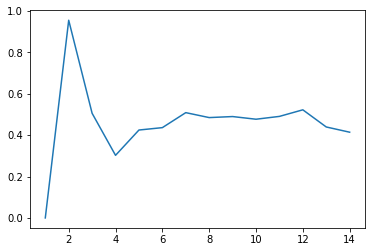

In [140]:
x=[]
y=[]
for i in range(1,15):
    K=Kmeans(n_clusters=i,select="k-means++",n_init=10,max_iter=300)
    K.calc(X)
    x.append(i)
    y.append(silhouette(X,K.labels))
plt.plot(x,y)
plt.show()

In [141]:
K=Kmeans(n_clusters=N,select="random", n_init=10,max_iter=300)
K.calc(X)
K.labels

array([0, 2, 0, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 2])

In [142]:
K=Kmeans(n_clusters=11,select="k-means++",n_init=10,max_iter=300)
K.calc(X)
K.inertia

0.17668833785689642

In [143]:
k = cluster.KMeans(n_clusters=N,init="k-means++",n_init=10,max_iter=300).fit(X)
k.inertia_

1.6835649840595952

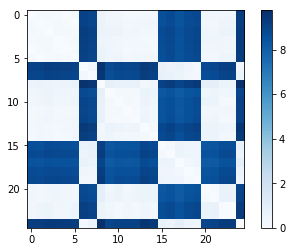

In [144]:
plt.imshow(sorted_dist_matrix(X,K.labels),cmap='Blues')
plt.colorbar()
plt.show()

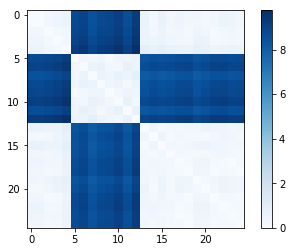

In [145]:
plt.imshow(sorted_dist_matrix(X,k.labels_),cmap='Blues')
plt.colorbar()
plt.show()